In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
df = pd.read_csv("train 3.csv")
df_test = pd.read_csv("test (4).csv")

# Añadimos el fichero adicional de precipitaciones para añadir más variables explicativas y mejorar el modelo

df_lluvia = pd.read_csv("percipitation (1).csv")

In [2]:
# Tenemos que concatenar en una misma celda tanto de la ciudad como de la fecha, llamandola "date"

df_lluvia["date"] = df_lluvia["date"].astype(str)
indice_lluvia = df_lluvia["City"] + " " + df_lluvia["date"]
df_lluvia["Indice"] = indice_lluvia

# Borramos columnas que no nos interesan
del(df_lluvia["date"])
del(df_lluvia["City"])

# Nuevo índice, reemplazando los mínimos valores (-9999) por 0
df_lluvia = df_lluvia.set_index('Indice')
df_lluvia = df_lluvia.replace(-9999,0)
df_lluvia

percipitation
Indice                              
Las Palmas 2019-12-02              8
Las Palmas 2019-12-03              4
Las Palmas 2019-12-04             20
Las Palmas 2019-12-05            214
Las Palmas 2019-12-06             22
...                              ...
Tampere 2022-10-27                 0
Tampere 2022-10-28                 0
Tampere 2022-10-29                 0
Tampere 2022-10-30                 0
Tampere 2022-10-31                 0

[165075 rows x 1 columns]

In [3]:
# Pasamos la columna "date" a string
df["date"] = df["date"].astype(str)

# Concatenación de ambas columnas (city y date)
indice_df = df["city"] + " " + df["date"]
df["Indice"] = indice_df


# Transformación de "country" y "city" de categorica a numérica y de "date" en formato fecha
df["country"] = df['country'].astype('category').cat.codes
df["city"] = df['city'].astype('category').cat.codes
df['date'] = pd.to_datetime(df['date'])

# Nuevo índice
df= df.set_index('Indice')

# Combinamos en train la columna de LLuvia
df= pd.merge(df, df_lluvia, on ='Indice', how ='left')
# Para mejorar la calidad del modelo, es interesante la creación de una columna adicional con las congestiones medias
ciudades = df["city"].unique()
medias_ciudades = []
for ciudad in ciudades:
    media = df["congestion"][df["city"] == ciudad].mean()
    medias_ciudades.append(media)
city2 = list(df["city"])
medias = []
for i in range(len(city2)):
    contador =  0
    for ciudad2 in ciudades:
        if ciudad2 == city2[i]:
            medias.append(medias_ciudades[contador])
        else:
            contador = contador + 1
            continue
df["congestion_media"] = medias

In [4]:
# Creamos otras tres columnas más adicionales a partir de la columna fecha "date" para expresar el año, mes, día de la semana y día del año

df_año = df['date'].dt.year 
df["año"] = df_año
df_mes = df['date'].dt.month 
df["mes"] = df_mes
df_semana = df['date'].dt.weekday
df["semana"] = df_semana
df_dia = df['date'].dt.dayofyear 
df["dia"] = df_dia

#Creamos una variable que indique la densidad de población de cada ciudad
densidad_ciudades = [2268.87,4547,5100,1961.5,1648.54,770,891,2700,3050,8861,6731.98,21423,1782,492,2457,1599,
                     4713,19133,1089,1123,4588,2799,1694,2200,2232,2652.98,2424.42,2300,2025.4,6518.1,5565,8333.74,
                     1677,15992.2,5418.47,1440.58,4896.55,2700,1769,7300]
densidades = []
for j in range(len(city2)):
    contador2 =  0
    for ciudad4 in ciudades:
        if ciudad4 == city2[j]:
            densidades.append(densidad_ciudades[contador2])
        else:
            contador2 = contador2 + 1
            continue
df["densidad_poblacion"] = densidades

In [5]:
# Después de crear una columna sobre la densidad, es importante conocer la población de cada una de estas ciudades

poblacion = [283869,1897000,181726,201837,379526,1309000,602481,426538,631695,160649,232741,2273305,3645000,569352,1086000,554649,1472000,
                     700000,1756000,124391,544107,388367,313396,1352000,2873000,223209,200336,766683,540365,504718,214349,1830000,331577,1620000,
                     3223000,571026,688771,579281,344146,975551]
poblaciones = []
for p in range(len(city2)):
    contador15 =  0
    for ciudad15 in ciudades:
        if ciudad15 == city2[p]:
            poblaciones.append(poblacion[contador15])
        else:
            contador15 = contador15 + 1
            continue
df["numero_habitantes"] = poblaciones

# Es interesante incluir también si estas ciudades tienen rio, ya que mejora el modelo y podría servir para explicar la mayor congestión en zonas de puentes

rio_ciudades = [1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,0,1,1,1,1]
rios = []
for m in range(len(city2)):
    contador10 =  0
    for ciudad10 in ciudades:
        if ciudad10 == city2[m]:
            rios.append(rio_ciudades[contador10])
        else:
            contador10 = contador10 + 1
            continue
df["rio"] = rios


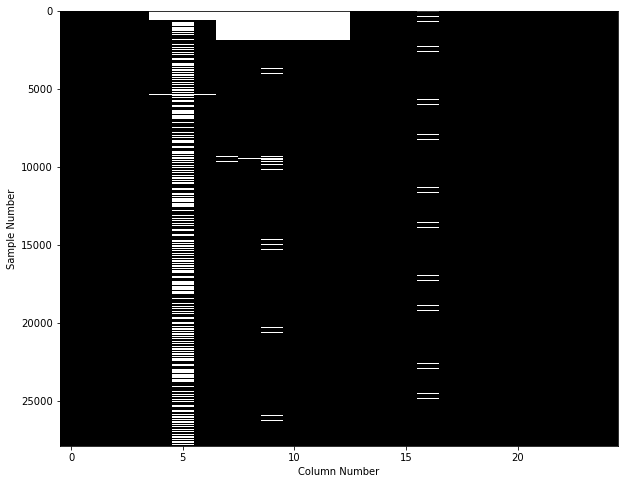

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

In [7]:
# Reemplazamos los NAN con SimpleImputer (a través de la mediana) para crear un nuevo DataFrame, y con ello, un mejor modelo debido a la gran cantidad de NaN del test

from sklearn.impute import SimpleImputer

nuevo_df = df

# Dividimos variable en numéricas y objeto

df_numericas = nuevo_df.drop(['country','city','date'],axis=1)

df_objeto = nuevo_df.drop(['congestion', 'driving',
                                   'transit', 'walking', 'retail_and_recreation', 'grocery_and_pharmacy', 'parks',
                                   'transit_stations', 'workplaces', 'residential', 'commercial', 'utilities',
                                   'other',"año","mes","semana","numero_habitantes","rio","densidad_poblacion",
                        "percipitation","congestion_media","dia"],axis=1)

simple_impute = SimpleImputer(missing_values=np.nan,strategy='median',verbose=0)
Nuevo_df_numericas=simple_impute.fit(df_numericas).transform(df_numericas)
Nuevo_df_numericas=pd.DataFrame(Nuevo_df_numericas,columns=(df_numericas.columns))
df_objeto.index = range(Nuevo_df_numericas.shape[0])
df=pd.concat([df_objeto,Nuevo_df_numericas],axis=1)

# se vuelve a crear un ídice con la ciudad y fecha ya que SimpleImputer la elimina

df.insert(0, "id", indice_df, True)
df = df.set_index('id')

# Reemplazamos los NaN de la variable "percipitation"
df['percipitation'] = nuevo_df['percipitation'].fillna(0)

df

country  city       date  congestion  driving  transit  \
id                                                                              
Graz 2019-12-30              0    19 2019-12-30        23.0     1.62     1.60   
Vienna 2019-12-30            0    39 2019-12-30        18.0     1.62     1.60   
Brussels 2019-12-30          1     7 2019-12-30        24.0     1.62     1.60   
Charleroi 2019-12-30         1    11 2019-12-30        15.0     1.62     1.60   
Brno 2019-12-30              2     6 2019-12-30        14.0     1.62     1.60   
...                        ...   ...        ...         ...      ...      ...   
Malaga 2021-11-30           16    27 2021-11-30        26.0    18.39   153.15   
Seville 2021-11-30          16    36 2021-11-30        24.0    10.57   199.62   
Gothenburg 2021-11-30       17    18 2021-11-30        43.0    21.97    26.79   
Malmo 2021-11-30            17    28 2021-11-30        23.0    21.83    15.32   
Stockholm 2021-11-30        17    37 2021-11-30        44.0    31.31    30.30   

                       walking  retail_and_recreation  grocery_and_pharmacy  \
id                                                                            
Graz 2019-12-30          -4.86                  -24.0                  -3.0   
Vienna 2019-12-30        -4.86                  -24.0                  -3.0   
Brussels 2019-12-30      -4.86                  -24.0                  -3.0   
Charleroi 2019-12-30     -4.86                  -24.0                  -3.0   
Brno 2019-12-30          -4.86                  -24.0                  -3.0   
...                        ...                    ...                   ...   
Malaga 2021-11-30        16.17                   -6.0                  13.0   
Seville 2021-11-30       -4.94                   -6.0                  11.0   
Gothenburg 2021-11-30    39.40                   -7.0                   2.0   
Malmo 2021-11-30         21.07                   -3.0                  10.0   
Stockholm 2021-11-30     13.39                  -16.0                  -7.0   

                       parks  ...  other  percipitation  congestion_media  \
id                            ...                                           
Graz 2019-12-30         10.0  ...    1.0            0.0         23.022956   
Vienna 2019-12-30       10.0  ...    1.0            0.0         24.955524   
Brussels 2019-12-30     10.0  ...    1.0            0.0         30.308465   
Charleroi 2019-12-30    10.0  ...    1.0            0.0         14.048780   
Brno 2019-12-30         10.0  ...    1.0            0.0         25.117647   
...                      ...  ...    ...            ...               ...   
Malaga 2021-11-30        2.0  ...    1.0            0.0         14.309900   
Seville 2021-11-30      -5.0  ...    1.0            0.0         14.268293   
Gothenburg 2021-11-30   13.0  ...    1.0            6.0         15.773314   
Malmo 2021-11-30        10.0  ...    1.0           13.0         14.058824   
Stockholm 2021-11-30    -5.0  ...    1.0            0.0         25.149211   

                          año   mes  semana    dia  densidad_poblacion  \
id                                                                       
Graz 2019-12-30        2019.0  12.0     0.0  364.0             2268.87   
Vienna 2019-12-30      2019.0  12.0     0.0  364.0             4547.00   
Brussels 2019-12-30    2019.0  12.0     0.0  364.0             5100.00   
Charleroi 2019-12-30   2019.0  12.0     0.0  364.0             1961.50   
Brno 2019-12-30        2019.0  12.0     0.0  364.0             1648.54   
...                       ...   ...     ...    ...                 ...   
Malaga 2021-11-30      2021.0  11.0     1.0  334.0             1440.58   
Seville 2021-11-30     2021.0  11.0     1.0  334.0             4896.55   
Gothenburg 2021-11-30  2021.0  11.0     1.0  334.0             2700.00   
Malmo 2021-11-30       2021.0  11.0     1.0  334.0             1769.00   
Stockholm 2021-11-30   2021.0  11.0     1.0  334.0 

In [8]:
df.describe()

country          city    congestion       driving       transit  \
count  27880.000000  27880.000000  27880.000000  27880.000000  27880.000000   
mean       9.400000     19.500000     23.625897      2.128118     13.365787   
std        5.238414     11.543603     13.070731     38.453015     73.832356   
min        0.000000      0.000000      0.000000    -93.830000    -95.890000   
25%        6.000000      9.750000     14.000000    -22.900000      0.250000   
50%       10.000000     19.500000     21.000000      1.620000      1.600000   
75%       14.000000     29.250000     32.000000     26.322500      3.082500   
max       17.000000     39.000000    137.000000    240.210000    842.680000   

            walking  retail_and_recreation  grocery_and_pharmacy  \
count  27880.000000           27880.000000          27880.000000   
mean       1.011744             -27.821234             -4.427224   
std       53.320889              23.580239             19.797582   
min      -97.570000             -98.000000            -96.000000   
25%      -37.550000             -41.000000            -13.000000   
50%       -4.860000             -24.000000             -3.000000   
75%       31.365000             -11.000000              5.000000   
max      311.440000              54.000000            208.000000   

              parks  transit_stations  ...         other  percipitation  \
count  27880.000000      27880.000000  ...  27880.000000   27880.000000   
mean      18.280882        -32.277439  ...      0.976040      10.619620   
std       50.822105         20.840538  ...      4.745785      39.254221   
min      -97.000000        -94.000000  ...   -776.000000       0.000000   
25%      -13.000000        -45.000000  ...      1.000000       0.000000   
50%       10.000000        -32.000000  ...      1.000000       0.000000   
75%       41.000000        -19.000000  ...      1.000000       0.000000   
max      356.000000         69.000000  ...     93.000000    1535.000000   

       congestion_media           año           mes        semana  \
count      27880.000000  27880.000000  27880.000000  27880.000000   
mean          23.625897   2020.470588      6.314204      2.982783   
std            6.486111      0.504859      3.324718      2.003546   
min           13.823529   2019.000000      1.000000      0.000000   
25%           18.380918   2020.000000      3.000000      1.000000   
50%           24.225251   2020.000000      6.000000      3.000000   
75%           27.480631   2021.000000      9.000000      5.000000   
max           39.529412   2021.000000     12.000000      6.000000   

                dia  densidad_poblacion  numero_habitantes           rio  
count  27880.000000        27880.000000       2.788000e+04  27880.000000  
mean     177.083214         4421.683250       9.142910e+05      0.725000  
std      101.712960         4648.534047       8.630470e+05      0.446522  
min        1.000000          492.000000       1.243910e+05      0.000000  
25%       89.000000         1750.250000       3.270318e+05      0.000000  
50%      177.000000         2554.990000       5.701890e+05      1.000000  
75%      264.000000         5179.617500       1.319750e+06      1.000000  
max      366.000000        21423.000000       3.645000e+06      1.000000  

[8 rows x 24 columns]

In [9]:
df.shape #El número de columnas y la longitud del conjunto de datos.

(27880, 25)

In [10]:
df.head(20)

country  city       date  congestion  driving  transit  \
id                                                                              
Graz 2019-12-30              0    19 2019-12-30        23.0     1.62      1.6   
Vienna 2019-12-30            0    39 2019-12-30        18.0     1.62      1.6   
Brussels 2019-12-30          1     7 2019-12-30        24.0     1.62      1.6   
Charleroi 2019-12-30         1    11 2019-12-30        15.0     1.62      1.6   
Brno 2019-12-30              2     6 2019-12-30        14.0     1.62      1.6   
Prague 2019-12-30            2    34 2019-12-30        19.0     1.62      1.6   
Copenhagen 2019-12-30        3    13 2019-12-30        18.0     1.62      1.6   
Tallinn 2019-12-30           4    38 2019-12-30        27.0     1.62      1.6   
Helsinki 2019-12-30          5    22 2019-12-30        17.0     1.62      1.6   
Grenoble 2019-12-30          6    20 2019-12-30        28.0     1.62      1.6   
Lille 2019-12-30             6    24 2019-12-30        20.0     1.62      1.6   
Paris 2019-12-30             6    31 2019-12-30        37.0     1.62      1.6   
Berlin 2019-12-30            7     3 2019-12-30        26.0     1.62      1.6   
Bremen 2019-12-30            7     5 2019-12-30        24.0     1.62      1.6   
Cologne 2019-12-30           7    12 2019-12-30        21.0     1.62      1.6   
Dresden 2019-12-30           7    15 2019-12-30        25.0     1.62      1.6   
Munich 2019-12-30            7    30 2019-12-30        16.0     1.62      1.6   
Athens 2019-12-30            8     1 2019-12-30        50.0     1.62      1.6   
Budapest 2019-12-30          9     9 2019-12-30        26.0     1.62      1.6   
Cork 2019-12-30             10    14 2019-12-30        21.0     1.62      1.6   

                       walking  retail_and_recreation  grocery_and_pharmacy  \
id                                                                            
Graz 2019-12-30          -4.86                  -24.0                  -3.0   
Vienna 2019-12-30        -4.86                  -24.0                  -3.0   
Brussels 2019-12-30      -4.86                  -24.0                  -3.0   
Charleroi 2019-12-30     -4.86                  -24.0                  -3.0   
Brno 2019-12-30          -4.86                  -24.0                  -3.0   
Prague 2019-12-30        -4.86                  -24.0                  -3.0   
Copenhagen 2019-12-30    -4.86                  -24.0                  -3.0   
Tallinn 2019-12-30       -4.86                  -24.0                  -3.0   
Helsinki 2019-12-30      -4.86                  -24.0                  -3.0   
Grenoble 2019-12-30      -4.86                  -24.0                  -3.0   
Lille 2019-12-30         -4.86                  -24.0                  -3.0   
Paris 2019-12-30         -4.86                  -24.0                  -3.0   
Berlin 2019-12-30        -4.86                  -24.0                  -3.0   
Bremen 2019-12-30        -4.86                  -24.0                  -3.0   
Cologne 2019-12-30       -4.86                  -24.0                  -3.0   
Dresden 2019-12-30       -4.86                  -24.0                  -3.0   
Munich 2019-12-30        -4.86                  -24.0                  -3.0   
Athens 2019-12-30        -4.86                  -24.0                  -3.0   
Budapest 2019-12-30      -4.86                  -24.0                  -3.0   
Cork 2019-12-30          -4.86                  -24.0                  -3.0   

                       parks  ...  other  percipitation  congestion_media  \
id                            ...                                           
Graz 2019-12-30         10.0  ...    1.0            0.0         23.022956   
Vienna 2019-12-30       10.0  ...    1.0            0.0         24.955524   
Brussels 2019-12-30     10.0  ...    1.0            0.0         30.308465   
Charleroi 2019-12-30    10.0  ...    1.0            0.0         14.048780   
Brno 2019-12-30         10.0  ...    1.

In [11]:
df.sort_values(by="congestion", ascending=False).head(9)
#Poznan, Wielkopolska, Polonia. 8 de febrero de 2021. Ataque de invierno en Polonia. 
#Dresden, Una gran Nevada.
#Grenoble, partido de Rugby entre Béziers y Oyonnax Rugby 
# Krakow, 5 de mayo, cercanía al día de la Constitución
# 6 de noviembre Atenas (el día de antes)--> Grecia confina todo el país el mes de noviembre ante el avance incontrolado de casos
# Madrid, 9 de enero de 2021, FILOMENA

country  city       date  congestion  driving  transit  \
id                                                                             
Poznan 2021-02-08          13    33 2021-02-08       137.0     4.82     1.60   
Dresden 2021-02-08          7    15 2021-02-08        90.0     0.12     1.60   
Krakow 2021-11-02          13    23 2021-11-02        87.0    29.25     1.60   
Bucharest 2021-05-20       15     8 2021-05-20        85.0    -1.88     1.60   
Grenoble 2020-10-29         6    20 2020-10-29        85.0    56.05     1.60   
Krakow 2021-05-05          13    23 2021-05-05        83.0     0.84     1.60   
Krakow 2020-09-30          13    23 2020-09-30        83.0    19.23     1.60   
Athens 2020-11-06           8     1 2020-11-06        82.0    73.07     1.60   
Madrid 2021-01-09          16    26 2021-01-09        81.0   -74.73   -61.23   

                      walking  retail_and_recreation  grocery_and_pharmacy  \
id                                                                           
Poznan 2021-02-08      -15.11                  -46.0                 -26.0   
Dresden 2021-02-08     -20.82                  -62.0                 -30.0   
Krakow 2021-11-02       -9.45                  -19.0                   8.0   
Bucharest 2021-05-20     3.42                  -24.0                   4.0   
Grenoble 2020-10-29     33.78                    4.0                  26.0   
Krakow 2021-05-05      -59.54                  -30.0                   0.0   
Krakow 2020-09-30      -22.90                  -20.0                 -17.0   
Athens 2020-11-06       15.10                  -18.0                  24.0   
Madrid 2021-01-09      -53.85                  -84.0                 -62.0   

                      parks  ...  other  percipitation  congestion_media  \
id                           ...                                           
Poznan 2021-02-08      -3.0  ...    1.0            0.0         31.869440   
Dresden 2021-02-08     -2.0  ...    1.0           25.0         29.192253   
Krakow 2021-11-02     -39.0  ...    1.0            0.0         38.322812   
Bucharest 2021-05-20  -34.0  ...    1.0           72.0         39.529412   
Grenoble 2020-10-29    25.0  ...    1.0            0.0         27.446198   
Krakow 2021-05-05     -14.0  ...    1.0            0.0         38.322812   
Krakow 2020-09-30     -32.0  ...    1.0            0.0         38.322812   
Athens 2020-11-06      18.0  ...    1.0            0.0         26.909613   
Madrid 2021-01-09     -21.0  ...    1.0          177.0         14.011478   

                         año   mes  semana    dia  densidad_poblacion  \
id                                                                      
Poznan 2021-02-08     2021.0   2.0     0.0   39.0             2025.40   
Dresden 2021-02-08    2021.0   2.0     0.0   39.0             1599.00   
Krakow 2021-11-02     2021.0  11.0     1.0  306.0             2300.00   
Bucharest 2021-05-20  2021.0   5.0     3.0  140.0             8333.74   
Grenoble 2020-10-29   2020.0  10.0     3.0  303.0             8861.00   
Krakow 2021-05-05     2021.0   5.0     2.0  125.0             2300.00   
Krakow 2020-09-30     2020.0   9.0     2.0  274.0             2300.00   
Athens 2020-11-06     2020.0  11.0     4.0  311.0            19133.00   
Madrid 2021-01-09     2021.0   1.0     5.0    9.0             5418.47   

                      numero_habitantes  rio  
id                                            
Poznan 2021-02-08              540365.0  1.0  
Dresden 2021-02-08             554649.0  1.0  
Krakow 2021-11-02              766683.0  1.0  
Bucharest 2021-05-20          1830000.0  1.0  
Grenoble 2020-10-29            160649.0  1.0  
Krakow 2021-05-05              766683.0  1.0  
Krakow 2020-09-30              766683.0  1.0  
Athens 2020-11-06              700000.0  0.0  
Madrid 2021-01-09             3223000.0  1.0  

[9 rows x 25 columns]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27880 entries, Graz 2019-12-30 to Stockholm 2021-11-30
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   country                27880 non-null  int8          
 1   city                   27880 non-null  int8          
 2   date                   27880 non-null  datetime64[ns]
 3   congestion             27880 non-null  float64       
 4   driving                27880 non-null  float64       
 5   transit                27880 non-null  float64       
 6   walking                27880 non-null  float64       
 7   retail_and_recreation  27880 non-null  float64       
 8   grocery_and_pharmacy   27880 non-null  float64       
 9   parks                  27880 non-null  float64       
 10  transit_stations       27880 non-null  float64       
 11  workplaces             27880 non-null  float64       
 12  residential            27880 non-nul

In [13]:
df.isna().sum() 

country                  0
city                     0
date                     0
congestion               0
driving                  0
transit                  0
walking                  0
retail_and_recreation    0
grocery_and_pharmacy     0
parks                    0
transit_stations         0
workplaces               0
residential              0
commercial               0
utilities                0
other                    0
percipitation            0
congestion_media         0
año                      0
mes                      0
semana                   0
dia                      0
densidad_poblacion       0
numero_habitantes        0
rio                      0
dtype: int64

In [14]:
df_numeric = df.drop(['country','city', "date","año", "other","dia","semana","transit"], axis=1)
df_numeric

congestion  driving  walking  retail_and_recreation  \
id                                                                           
Graz 2019-12-30              23.0     1.62    -4.86                  -24.0   
Vienna 2019-12-30            18.0     1.62    -4.86                  -24.0   
Brussels 2019-12-30          24.0     1.62    -4.86                  -24.0   
Charleroi 2019-12-30         15.0     1.62    -4.86                  -24.0   
Brno 2019-12-30              14.0     1.62    -4.86                  -24.0   
...                           ...      ...      ...                    ...   
Malaga 2021-11-30            26.0    18.39    16.17                   -6.0   
Seville 2021-11-30           24.0    10.57    -4.94                   -6.0   
Gothenburg 2021-11-30        43.0    21.97    39.40                   -7.0   
Malmo 2021-11-30             23.0    21.83    21.07                   -3.0   
Stockholm 2021-11-30         44.0    31.31    13.39                  -16.0   

                       grocery_and_pharmacy  parks  transit_stations  \
id                                                                     
Graz 2019-12-30                        -3.0   10.0             -32.0   
Vienna 2019-12-30                      -3.0   10.0             -32.0   
Brussels 2019-12-30                    -3.0   10.0             -32.0   
Charleroi 2019-12-30                   -3.0   10.0             -32.0   
Brno 2019-12-30                        -3.0   10.0             -32.0   
...                                     ...    ...               ...   
Malaga 2021-11-30                      13.0    2.0              -2.0   
Seville 2021-11-30                     11.0   -5.0              -6.0   
Gothenburg 2021-11-30                   2.0   13.0             -16.0   
Malmo 2021-11-30                       10.0   10.0             -19.0   
Stockholm 2021-11-30                   -7.0   -5.0             -32.0   

                       workplaces  residential  commercial  utilities  \
id                                                                      
Graz 2019-12-30             -28.0          7.0        97.0       50.0   
Vienna 2019-12-30           -28.0          7.0        91.0       51.0   
Brussels 2019-12-30         -28.0          7.0        99.0       50.0   
Charleroi 2019-12-30        -28.0          7.0        91.0       52.0   
Brno 2019-12-30             -28.0          7.0       112.0       51.0   
...                           ...          ...         ...        ...   
Malaga 2021-11-30           -12.0          2.0       106.0       51.0   
Seville 2021-11-30           -9.0          1.0       102.0       52.0   
Gothenburg 2021-11-30       -24.0          8.0        99.0       52.0   
Malmo 2021-11-30            -25.0          7.0        93.0       54.0   
Stockholm 2021-11-30        -32.0          9.0        93.0       51.0   

                       percipitation  congestion_media   mes  \
id                                                             
Graz 2019-12-30                  0.0         23.022956  12.0   
Vienna 2019-12-30                0.0         24.955524  12.0   
Brussels 2019-12-30              0.0         30.308465  12.0   
Charleroi 2019-12-30             0.0         14.048780  12.0   
Brno 2019-12-30                  0.0         25.117647  12.0   
...                              ...               ...   ...   
Malaga 2021-11-30                0.0         14.309900  11.0   
Seville 2021-11-30               0.0         14.268293  11.0   
Gothenburg 2021-11-30            6.0         15.773314  11.0   
Malmo 2021-11-30                13.0         14.058824  11.0   
Stockholm 2021-11-30             0.0         25.149211  11.0   

                       densidad_poblacion  numero_habitantes  rio  
id                                                                 
Graz 2019-12-30                   2268.87           283869.0  1.0  
Vienna 2019-12-30                 4547.00          1897000.0  1.0  
Brussels 2019-12

In [15]:
# Check number of duplicates while ignoring the index feature
n_duplicates = df_numeric.drop(labels=["congestion"], axis=1).duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 11 duplicates in your database.


/Users/gonzalomarin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


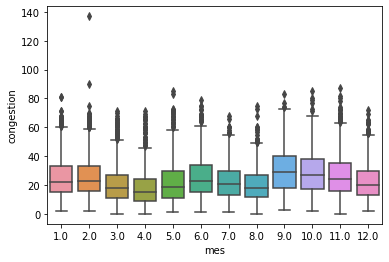

In [16]:
#Para observar la mediana (valor central),
#dónde se concentran la mayor cantidad de valores, o cuáles se distribuyen de forma inusual alcanzando los puntos extremos del esquema
#La caja termina en el 3º cuartil (75% de los datos)
sns.boxplot(df.mes, df.congestion)
plt.show()

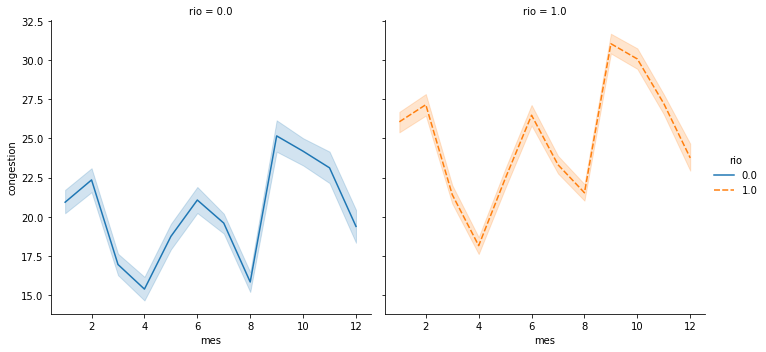

In [17]:
sns.relplot(
    data=df, x="mes", y="congestion", col="rio",
    hue="rio", style="rio", kind="line",
)

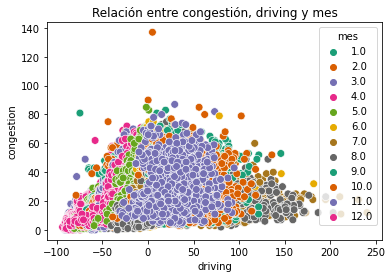

In [48]:
sns.scatterplot(x="driving", y="congestion", hue="mes", data=df, palette="Dark2", s=60)
plt.title("Relación entre congestión, driving y mes")
plt.show()

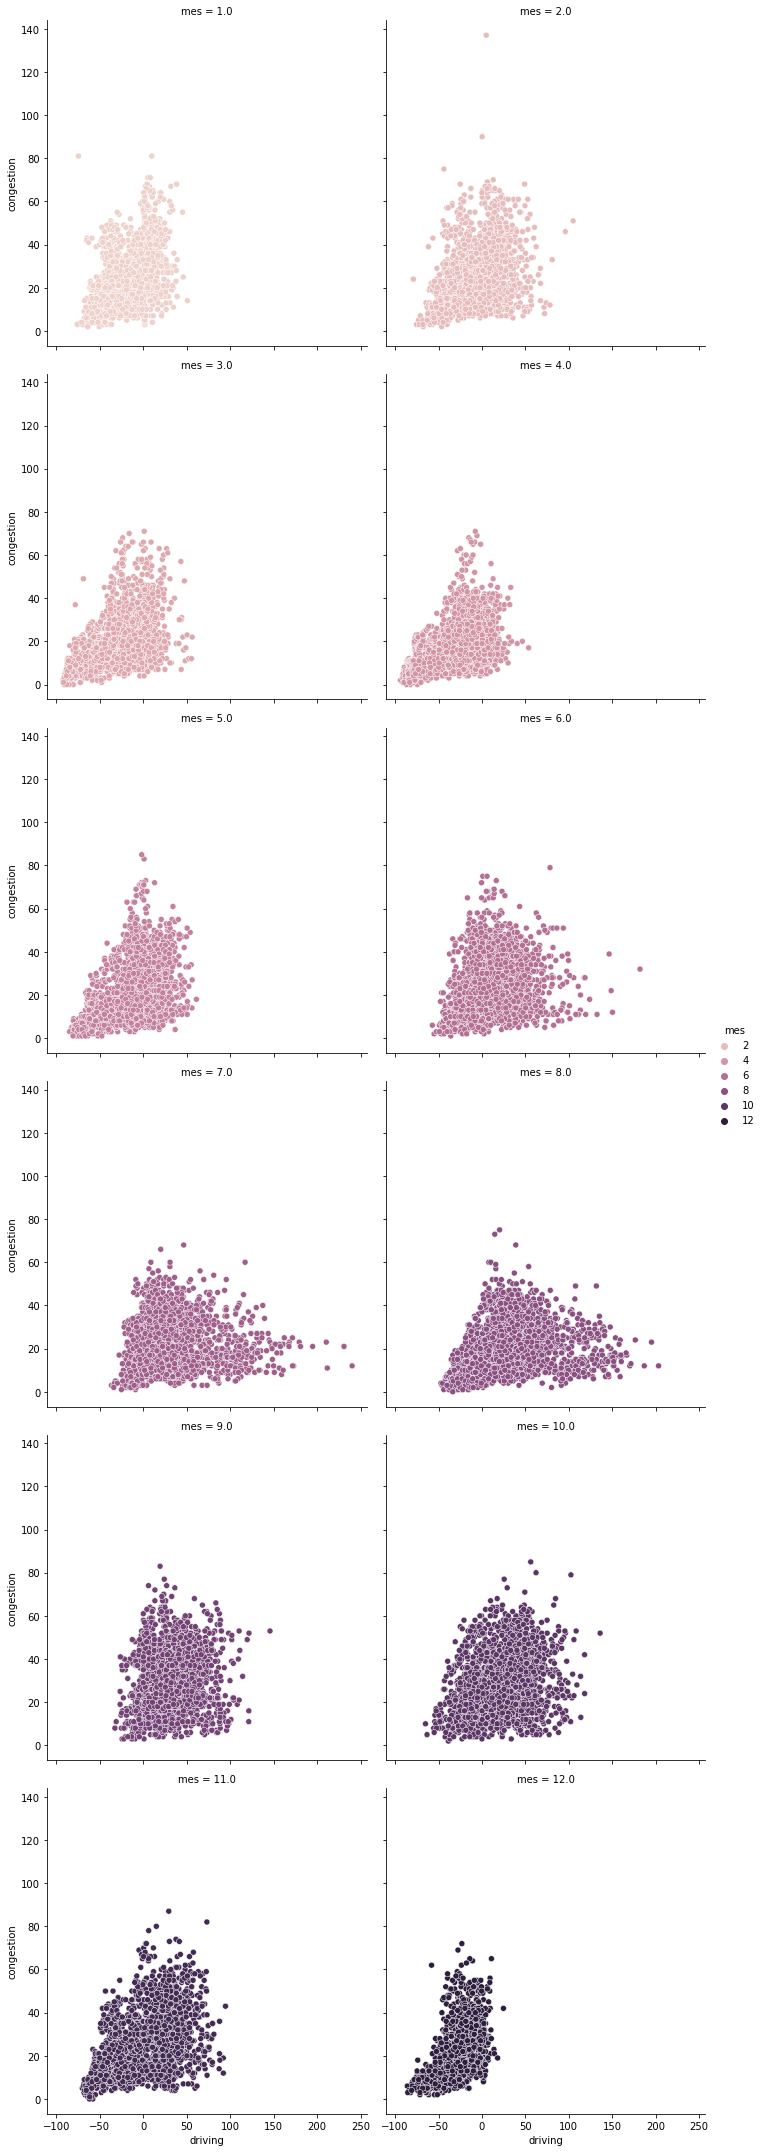

In [19]:
sns.relplot(data=df, x="driving", y="congestion", hue="mes", col="mes", col_wrap=2)


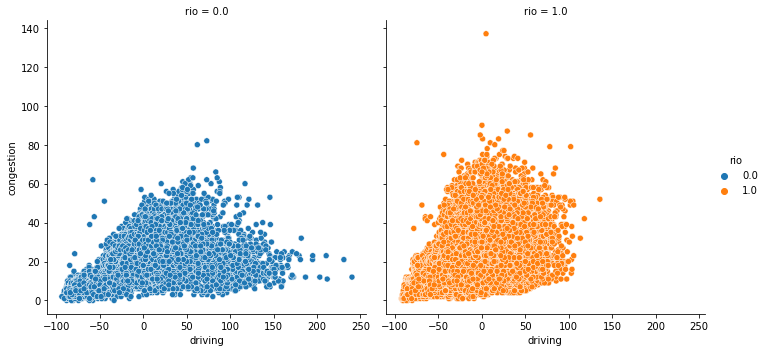

In [20]:
sns.relplot(data=df, x="driving", y="congestion", hue="rio", col="rio", col_wrap=2)
#Se observa que a medida que aumenta el driving en ciudades con rios (naranja), la congestión aumenta exponencialmente.
#Esto se debe a a existencia de tramos de carretera de la ciudad (puentes) donde se generan embudos.

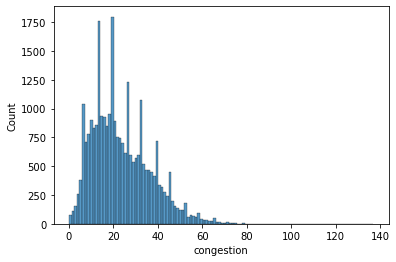

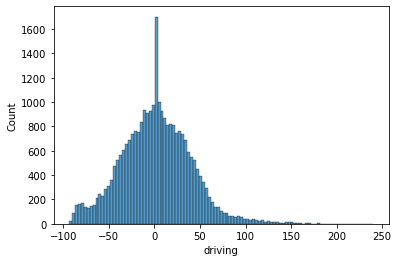

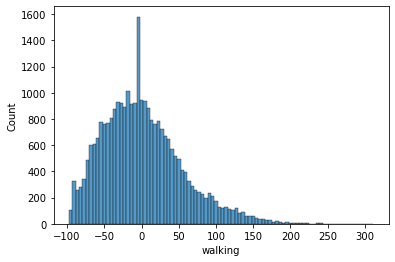

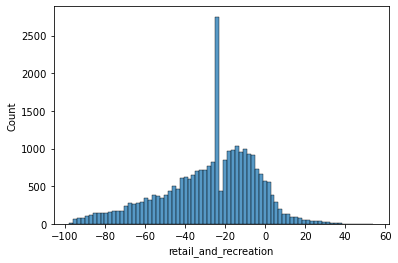

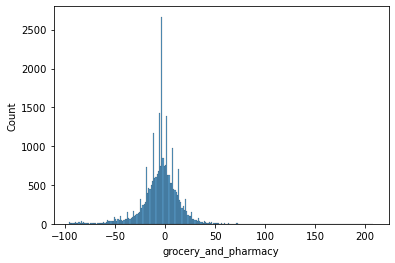

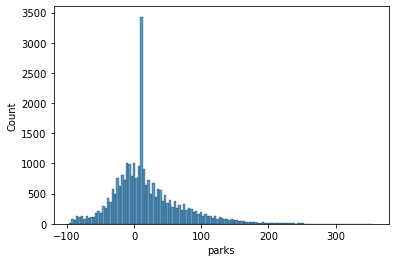

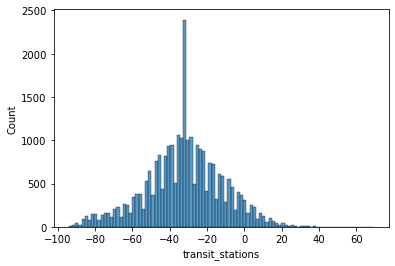

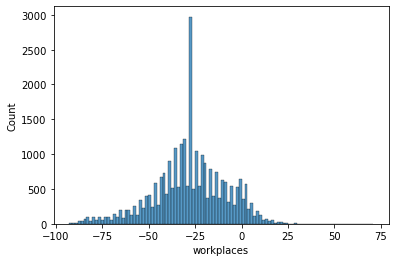

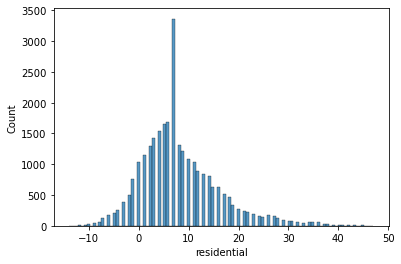

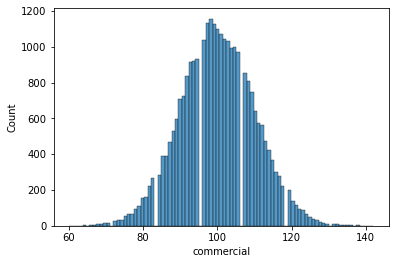

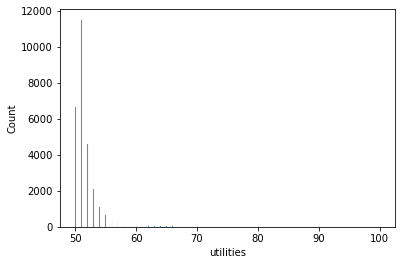

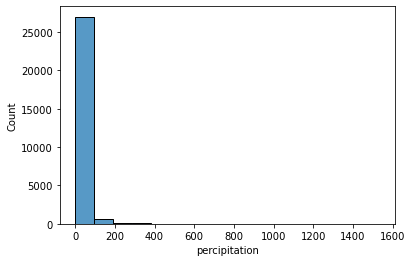

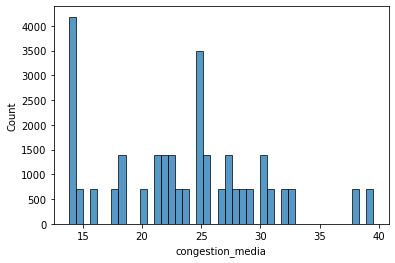

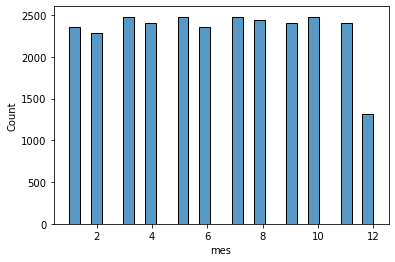

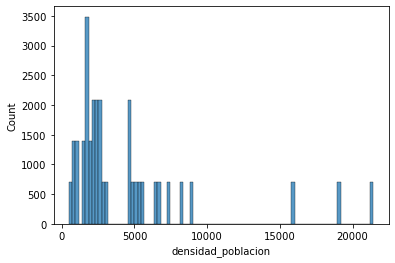

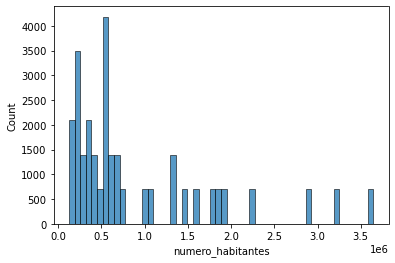

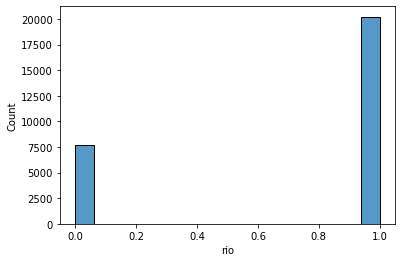

In [21]:
for column in df_numeric:
    sns.histplot(data = df_numeric, x = column)
    plt.show()

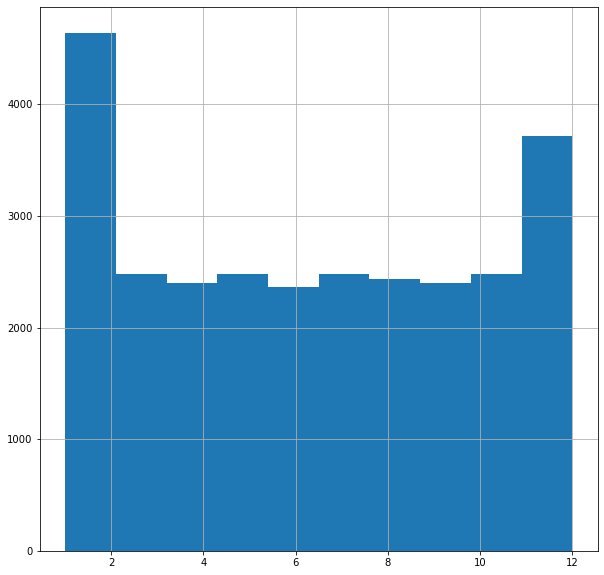

In [50]:
df_numeric.mes.hist(figsize=[10,10])
plt.show()

<AxesSubplot:xlabel='driving', ylabel='Count'>

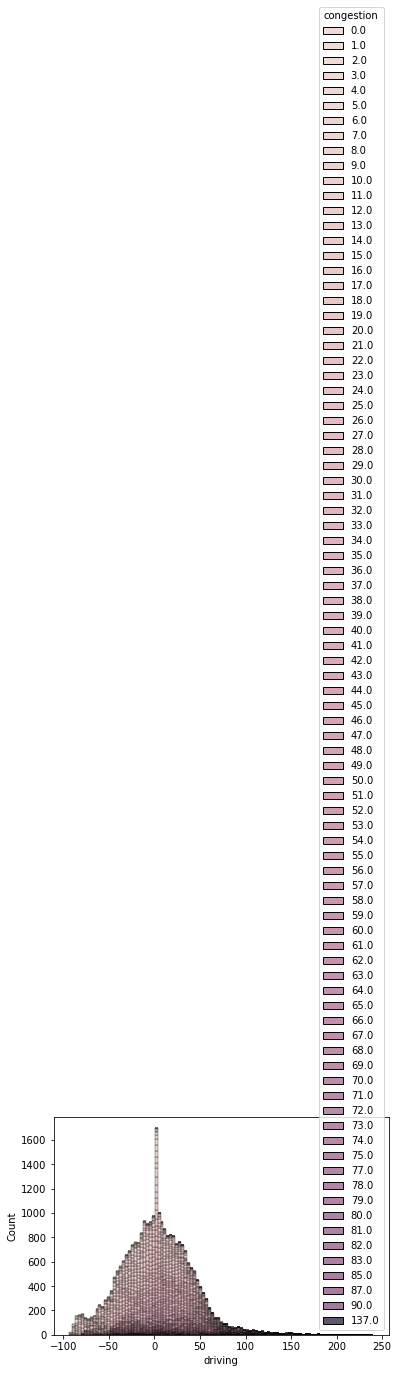

In [23]:
sns.histplot(df,x="driving", hue="congestion", multiple="stack")

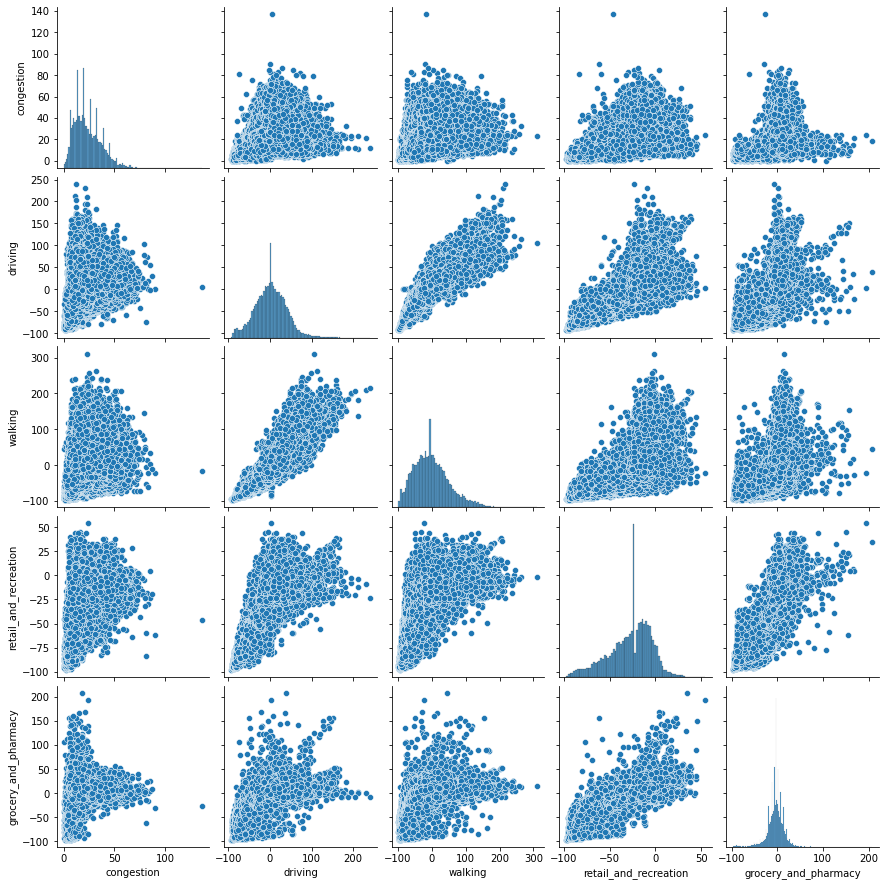

In [24]:
import seaborn as sns
sns.pairplot(df_numeric.iloc[:,0:5])

<AxesSubplot:>

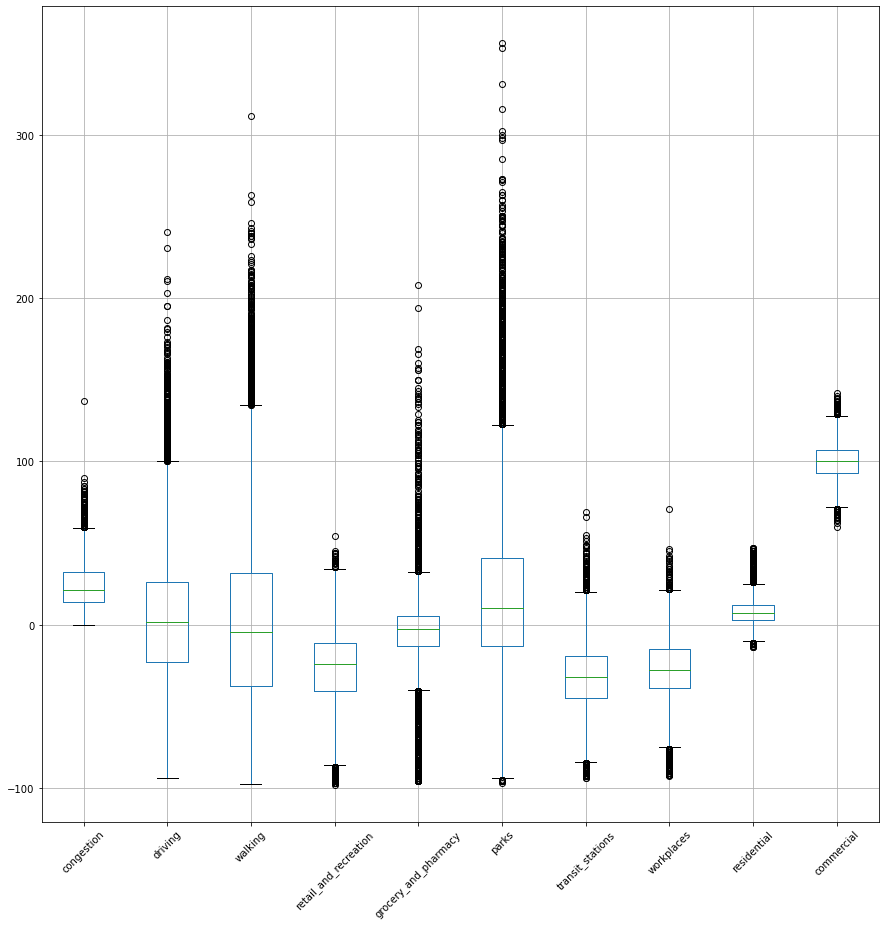

In [51]:
df_numeric.iloc[:,0:10].boxplot(rot=45,figsize=(15,15))

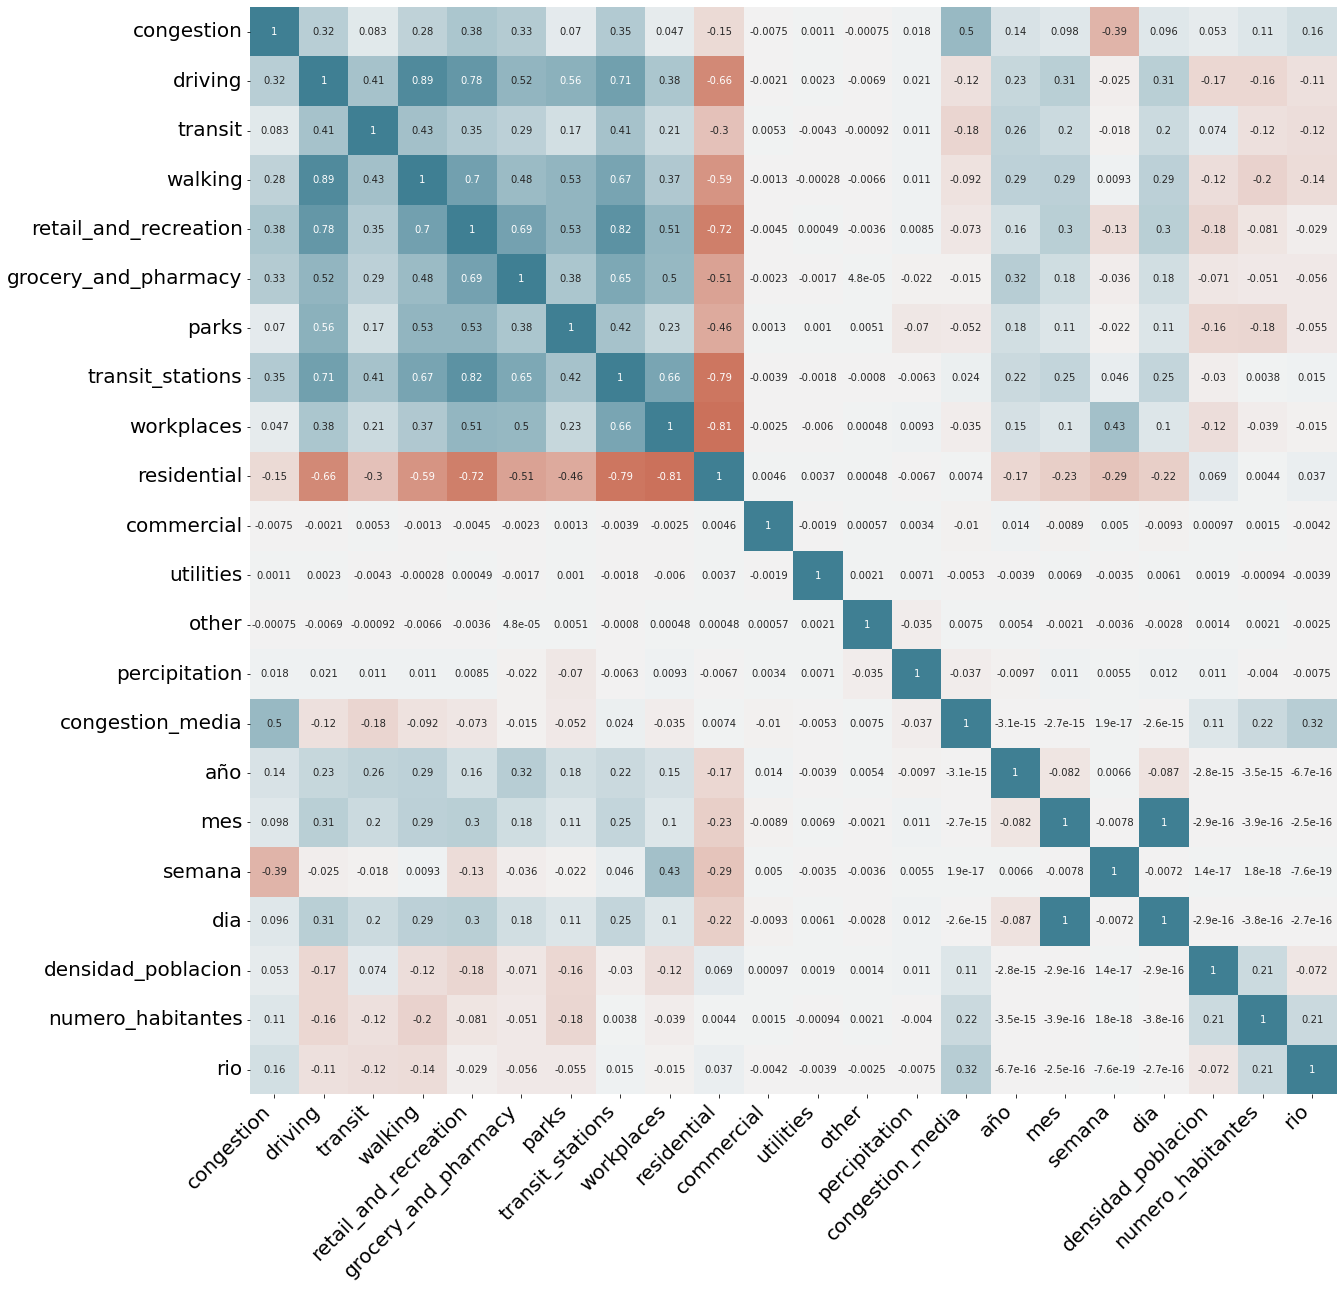

In [26]:
import numpy as np
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 20)

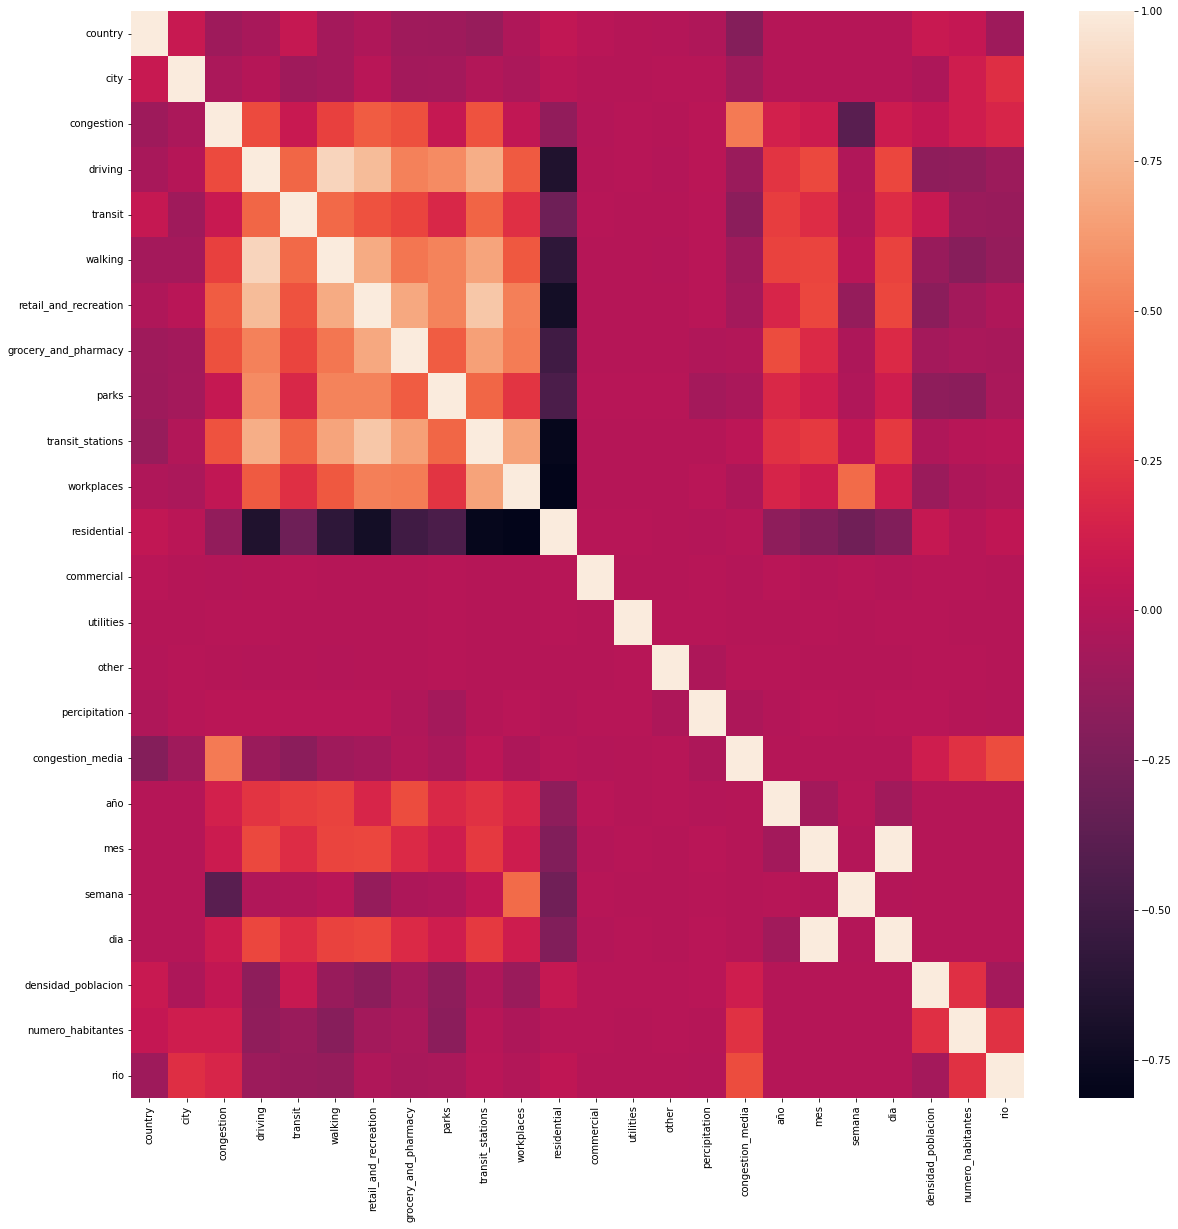

In [27]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())

plt.show()

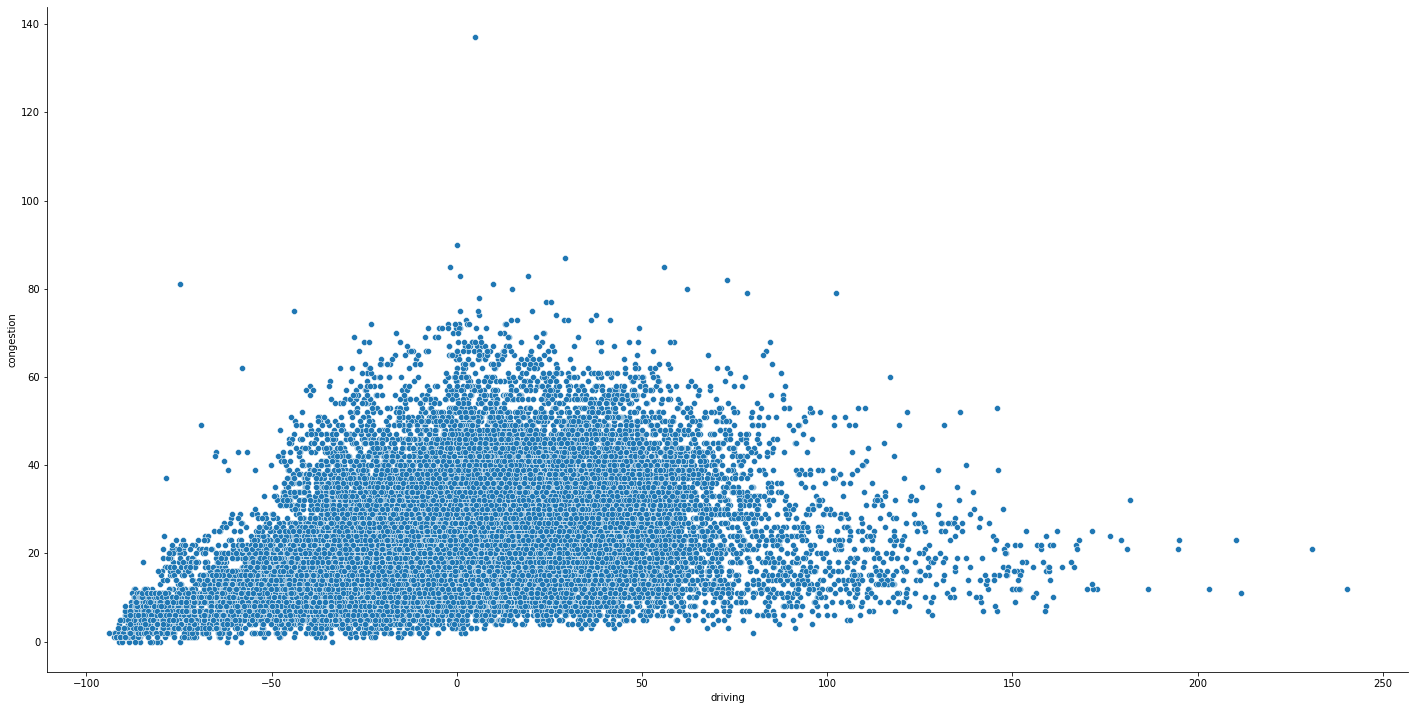

In [28]:
sns.pairplot(
    df,
    x_vars=["driving"],
    y_vars=["congestion"],height=10, aspect=2
)

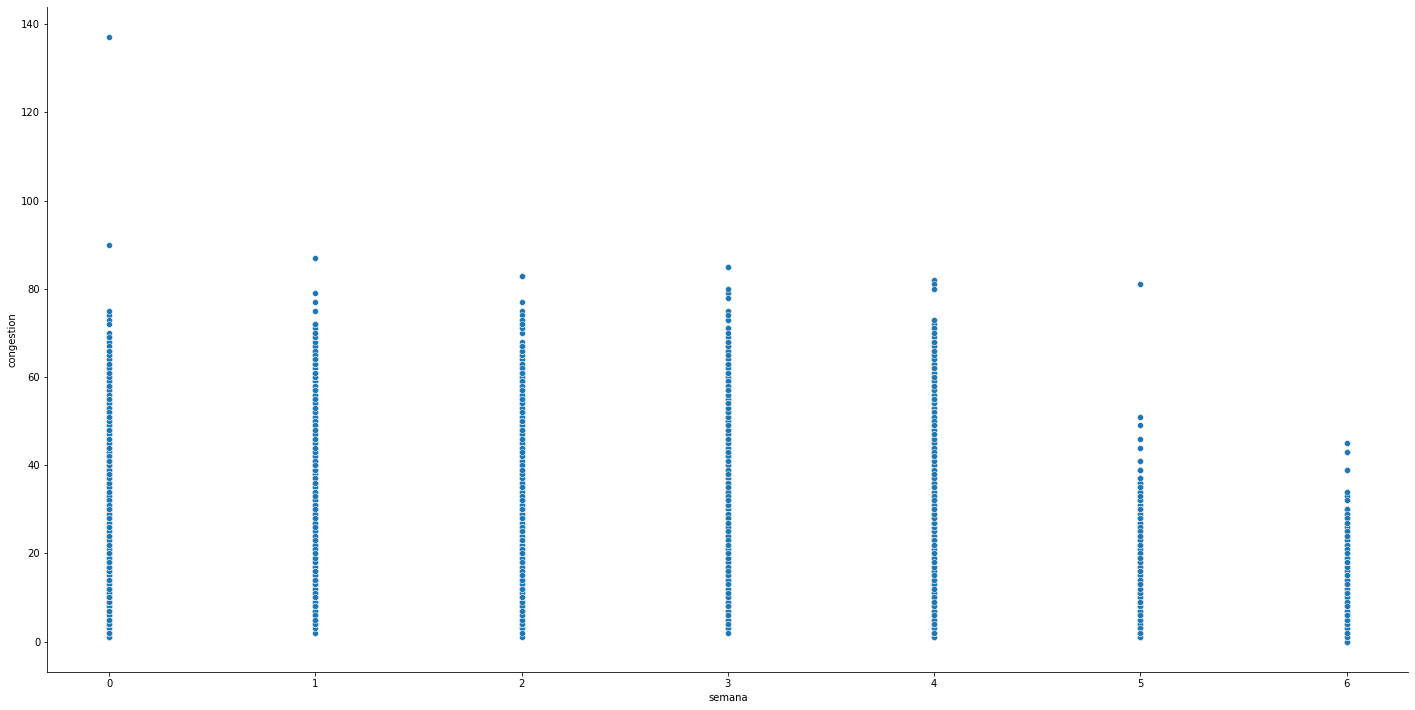

In [29]:
sns.pairplot(
    df,
    x_vars=["semana"],
    y_vars=["congestion"],height=10, aspect=2
)

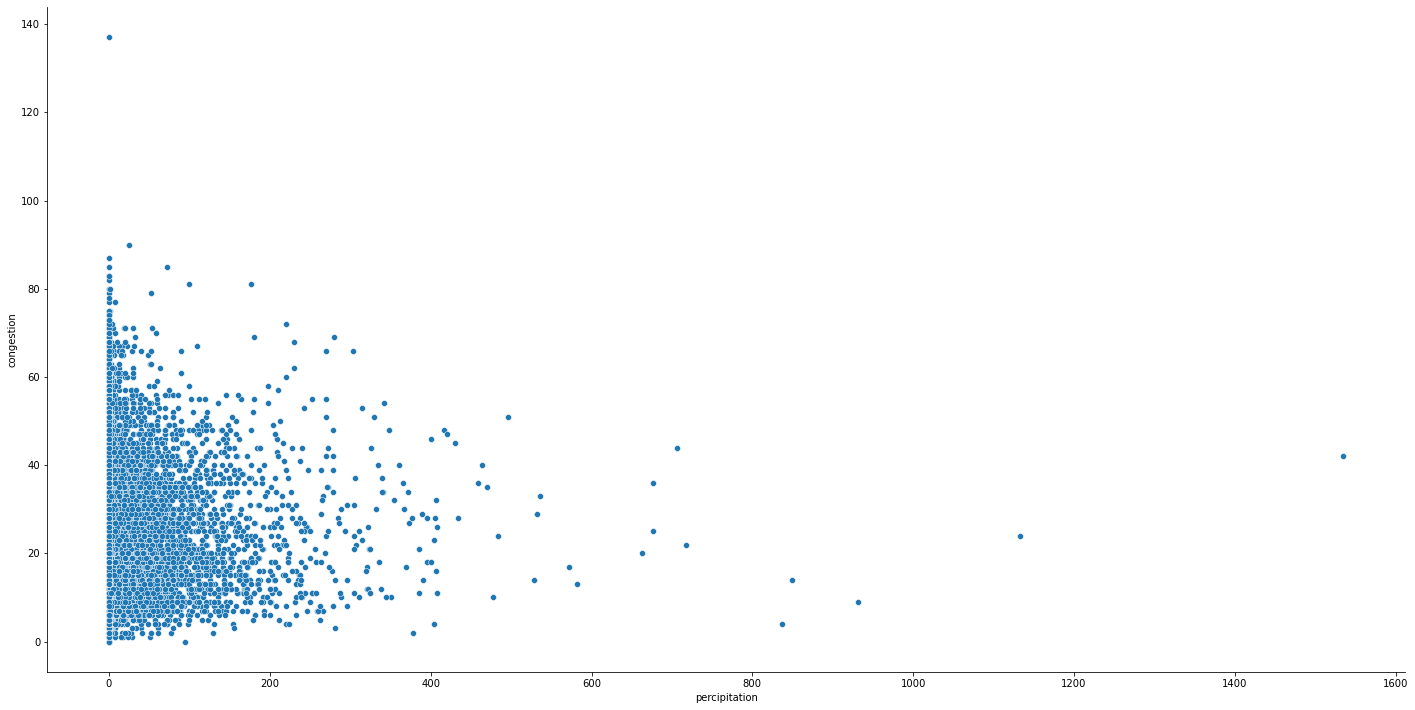

In [30]:
sns.pairplot(
    df,
    x_vars=["percipitation"],
    y_vars=["congestion"],height=10, aspect=2
)

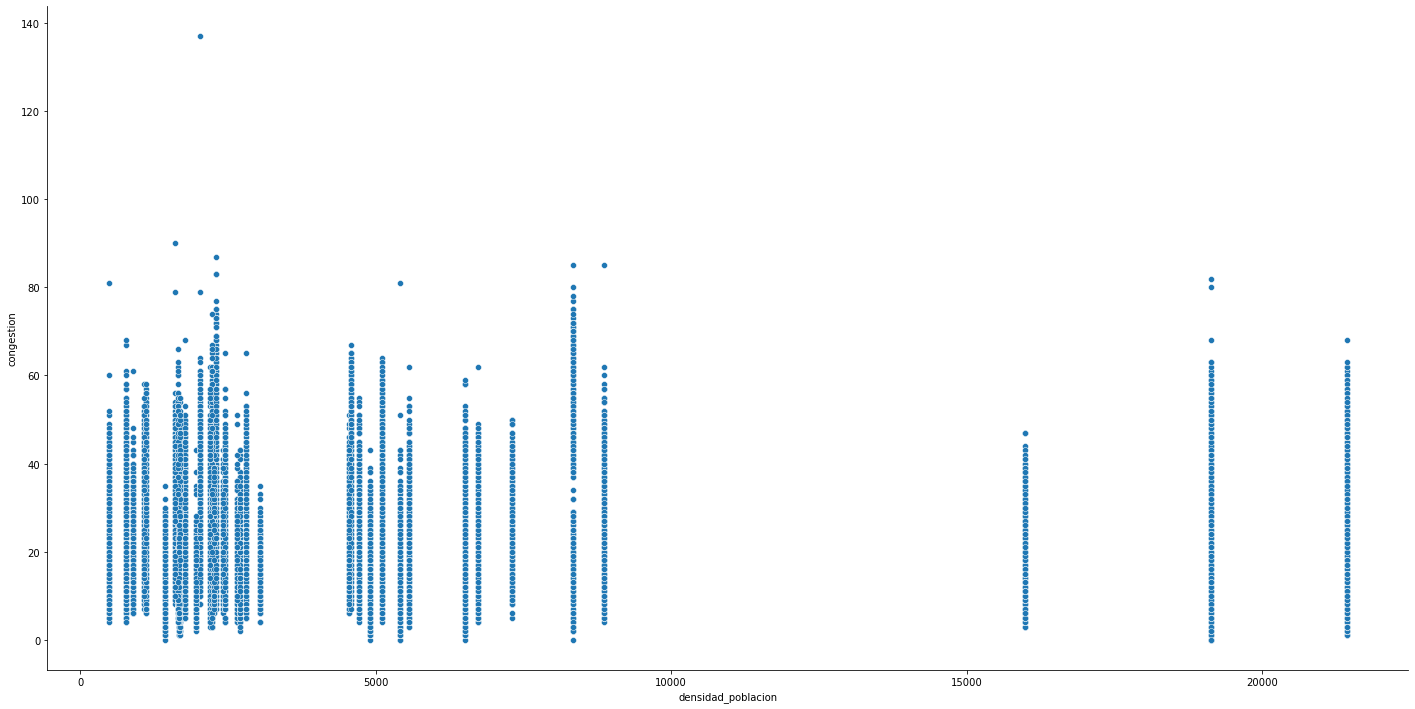

In [31]:
sns.pairplot(
    df,
    x_vars=["densidad_poblacion"],
    y_vars=["congestion"],height=10, aspect=2
)

In [32]:
from pandas_profiling import ProfileReport
report = ProfileReport(df.iloc[:,0:5])

In [33]:
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
# Comprobamos las variables del test

In [35]:
# Siguiendo los mismos pasos que antes, creamos las mismas variables para test, concatenando las columnas de "county", "city" y "date"
df_test["date"] = df_test["date"].astype(str)

indice_df_test = df_test["city"] + " " + df_test["date"]
df_test["Indice"] = indice_df_test

df_test["country"] = df_test['country'].astype('category').cat.codes
df_test["city"] = df_test['city'].astype('category').cat.codes

# también debemos añadir a "date" el datetime
df_test['date'] = pd.to_datetime(df_test['date'])
df_test= df_test.set_index('Indice')

# Se añade la variable de precipitaciones también
df_test= pd.merge(df_test, df_lluvia, on ='Indice', how ='left')

# Creamos la columna "congestion" ya que en este dataset no está (es la variable a predecir)
df_test["congestion"] = 0
df_test['congestion'] =  df_test['congestion'].astype('int64')

# Columna de las congestiones medias para el test
city3 = list(df_test["city"])
medias = []
for i in range(len(city3)):
    contador =  0
    for ciudad3 in ciudades:
        if ciudad3 == city3[i]:
            medias.append(medias_ciudades[contador])
        else:
            contador = contador + 1
            continue
df_test["congestion_media"] = medias

In [36]:
# Creamos una columna adicional a partir de la columna fecha "date" para idicar el año, mes, día de la semana y día
df_test_año = df_test['date'].dt.year 
df_test["año"] = df_test_año
df_test_mes = df_test['date'].dt.month 
df_test["mes"] = df_test_mes
df_test_semana = df_test['date'].dt.weekday
df_test["semana"] = df_test_semana
df_test_dia = df_test['date'].dt.dayofyear 
df_test["dia"] = df_test_dia

# variable densidad de poblacion por ciudad
densidades = []
for j in range(len(city3)):
    contador3 =  0
    for ciudad5 in ciudades:
        if ciudad5 == city3[j]:
            densidades.append(densidad_ciudades[contador3])
        else:
            contador3 = contador3 + 1
            continue
df_test["densidad_poblacion"] = densidades

In [37]:
# Creamos una variable que indique el número de habitantes de cada ciudad
poblaciones = []
for p in range(len(city3)):
    contador17 =  0
    for ciudad17 in ciudades:
        if ciudad17 == city3[p]:
            poblaciones.append(poblacion[contador17])
        else:
            contador17 = contador17 + 1
            continue
df_test["numero_habitantes"] = poblaciones

#Al igual que en train, hay que añadir la variable sobre la existencia de río en cada una de estas ciudades
rios = []
for m in range(len(city3)):
    contador11 =  0
    for ciudad11 in ciudades:
        if ciudad11 == city3[m]:
            rios.append(rio_ciudades[contador11])
        else:
            contador11 = contador11 + 1
            continue
df_test["rio"] = rios

In [38]:
from sklearn.impute import SimpleImputer

nuevo_df_test = df_test

# Dividimos variable en numéricas y objeto
df_test_numericas = nuevo_df_test.drop(['country','city','date'],axis=1)

df_test_objeto = nuevo_df_test.drop(['congestion', 'driving',
                                   'transit', 'walking', 'retail_and_recreation', 'grocery_and_pharmacy', 'parks',
                                   'transit_stations', 'workplaces', 'residential', 'commercial', 'utilities',
                                   'other',"año","mes","semana","numero_habitantes","rio","densidad_poblacion",
                        "percipitation","congestion_media","dia"],axis=1)

simple_impute = SimpleImputer(missing_values=np.nan,strategy='median',verbose=0)
Nuevo_df_test_numericas=simple_impute.fit(df_test_numericas).transform(df_test_numericas)
Nuevo_df_test_numericas=pd.DataFrame(Nuevo_df_test_numericas,columns=(df_test_numericas.columns))

# Concatenamos para sacar la tabla final
df_test_objeto.index = range(Nuevo_df_test_numericas.shape[0])
df_test=pd.concat([df_test_objeto,Nuevo_df_test_numericas],axis=1)

df_test.insert(0, "id", indice_df_test, True)

# Se establece como índice la variable "id" 
df_test = df_test.set_index('id')

# Reemplazamos los NaN de la variable "percipitation".

df_test['percipitation'] = df_test['percipitation'].fillna(0)

df_test

country  city       date  driving  transit  walking  \
id                                                                           
Graz 2021-12-01              0    19 2021-12-01     0.97    70.35     0.84   
Vienna 2021-12-01            0    39 2021-12-01     3.41    70.35   -22.73   
Brussels 2021-12-01          1     7 2021-12-01     7.53    82.52    24.04   
Charleroi 2021-12-01         1    11 2021-12-01    45.89    78.19    78.32   
Brno 2021-12-01              2     6 2021-12-01    20.92    70.35    58.20   
...                        ...   ...        ...      ...      ...      ...   
Malaga 2022-04-12           16    27 2022-04-12   112.19   384.75   202.69   
Seville 2022-04-12          16    36 2022-04-12    73.21   350.00   161.14   
Gothenburg 2022-04-12       17    18 2022-04-12    51.28    68.55    91.72   
Malmo 2022-04-12            17    28 2022-04-12    37.03    44.77    59.76   
Stockholm 2022-04-12        17    37 2022-04-12    37.75    63.48    53.78   

                       retail_and_recreation  grocery_and_pharmacy  parks  \
id                                                                          
Graz 2021-12-01                        -49.0                  16.0  -14.0   
Vienna 2021-12-01                      -53.0                  12.0   -8.0   
Brussels 2021-12-01                    -22.0                   9.0   -5.0   
Charleroi 2021-12-01                    11.0                  26.0  -17.0   
Brno 2021-12-01                        -18.0                  24.0   -6.0   
...                                      ...                   ...    ...   
Malaga 2022-04-12                        5.0                  18.0   31.0   
Seville 2022-04-12                     -11.0                   7.0  -19.0   
Gothenburg 2022-04-12                   -1.0                   3.0   60.0   
Malmo 2022-04-12                        -1.0                   9.0   55.0   
Stockholm 2022-04-12                   -16.0                 -12.0   20.0   

                       transit_stations  ...  percipitation  congestion  \
id                                       ...                              
Graz 2021-12-01                   -39.0  ...            6.0         0.0   
Vienna 2021-12-01                 -31.0  ...            3.0         0.0   
Brussels 2021-12-01               -27.0  ...            0.0         0.0   
Charleroi 2021-12-01              -13.0  ...            0.0         0.0   
Brno 2021-12-01                   -14.0  ...            5.0         0.0   
...                                 ...  ...            ...         ...   
Malaga 2022-04-12                  13.0  ...            0.0         0.0   
Seville 2022-04-12                -14.0  ...          123.0         0.0   
Gothenburg 2022-04-12             -21.0  ...            0.0         0.0   
Malmo 2022-04-12                  -14.0  ...            0.0         0.0   
Stockholm 2022-04-12              -28.0  ...            0.0         0.0   

                       congestion_media     año   mes  semana    dia  \
id                                                                     
Graz 2021-12-01               23.022956  2021.0  12.0     2.0  335.0   
Vienna 2021-12-01             24.955524  2021.0  12.0     2.0  335.0   
Brussels 2021-12-01           30.308465  2021.0  12.0     2.0  335.0   
Charleroi 2021-12-01          14.048780  2021.0  12.0     2.0  335.0   
Brno 2021-12-01               25.117647  2021.0  12.0     2.0  335.0   
...                                 ...     ...   ...     ...    ...   
Malaga 2022-04-12             14.309900  2022.0   4.0     1.0  102.0   
Seville 2022-04-12            14.268293  2022.0   4.0     1.0  102.0   
Gothenburg 2022-04-12         15.773314  2022.0   4.0     1.0  102.0   
Malmo 2022-04-12              14.058824  2022.0   4.0     1.0  102.0   
Stockholm 2022-04-12          25.149211  2022.0   4.0     1.0  102.0   

                       densidad_poblacion  numero_habitantes  rio  
id                       

In [39]:
df_test.describe()

country         city      driving      transit      walking  \
count  5320.000000  5320.000000  5320.000000  5320.000000  5320.000000   
mean      9.400000    19.500000    23.332829   102.876594    45.152086   
std       5.238813    11.544481    25.038454   114.552675    50.339434   
min       0.000000     0.000000   -71.450000   -77.230000   -81.790000   
25%       6.000000     9.750000     7.207500    66.977500    10.935000   
50%      10.000000    19.500000    21.670000    70.350000    36.875000   
75%      14.000000    29.250000    37.450000    73.485000    70.350000   
max      17.000000    39.000000   156.570000   918.180000   573.690000   

       retail_and_recreation  grocery_and_pharmacy        parks  \
count            5320.000000           5320.000000  5320.000000   
mean              -17.082707              7.476504     3.832331   
std                15.325887             21.641801    28.566860   
min               -96.000000            -94.000000   -74.000000   
25%               -24.000000             -1.000000   -15.000000   
50%               -17.000000              8.000000    -1.000000   
75%               -10.000000             16.000000    17.000000   
max                62.000000            239.000000   198.000000   

       transit_stations   workplaces  ...  percipitation  congestion  \
count       5320.000000  5320.000000  ...    5320.000000      5320.0   
mean         -22.620301   -19.709774  ...       7.742293         0.0   
std           14.150781    18.021398  ...      26.016603         0.0   
min          -92.000000   -90.000000  ...       0.000000         0.0   
25%          -31.000000   -28.000000  ...       0.000000         0.0   
50%          -23.000000   -17.000000  ...       0.000000         0.0   
75%          -13.000000    -8.000000  ...       0.000000         0.0   
max           52.000000   106.000000  ...     400.000000         0.0   

       congestion_media          año          mes       semana          dia  \
count       5320.000000  5320.000000  5320.000000  5320.000000  5320.000000   
mean          23.625897  2021.766917     4.511278     3.000000   121.075188   
std            6.486605     0.422834     4.222816     2.000188   128.895732   
min           13.823529  2021.000000     1.000000     0.000000     1.000000   
25%           18.380918  2022.000000     2.000000     1.000000    34.000000   
50%           24.225251  2022.000000     3.000000     3.000000    67.000000   
75%           27.480631  2022.000000     4.000000     5.000000   100.000000   
max           39.529412  2022.000000    12.000000     6.000000   365.000000   

       densidad_poblacion  numero_habitantes          rio  
count         5320.000000       5.320000e+03  5320.000000  
mean          4421.683250       9.142910e+05     0.725000  
std           4648.887625       8.631126e+05     0.446556  
min            492.000000       1.243910e+05     0.000000  
25%           1750.250000       3.270318e+05     0.000000  
50%           2554.990000       5.701890e+05     1.000000  
75%           5179.617500       1.319750e+06     1.000000  
max          21423.000000       3.645000e+06     1.000000  

[8 rows x 24 columns]

In [40]:
df_test.head()

country  city       date  driving  transit  walking  \
id                                                                          
Graz 2021-12-01             0    19 2021-12-01     0.97    70.35     0.84   
Vienna 2021-12-01           0    39 2021-12-01     3.41    70.35   -22.73   
Brussels 2021-12-01         1     7 2021-12-01     7.53    82.52    24.04   
Charleroi 2021-12-01        1    11 2021-12-01    45.89    78.19    78.32   
Brno 2021-12-01             2     6 2021-12-01    20.92    70.35    58.20   

                      retail_and_recreation  grocery_and_pharmacy  parks  \
id                                                                         
Graz 2021-12-01                       -49.0                  16.0  -14.0   
Vienna 2021-12-01                     -53.0                  12.0   -8.0   
Brussels 2021-12-01                   -22.0                   9.0   -5.0   
Charleroi 2021-12-01                   11.0                  26.0  -17.0   
Brno 2021-12-01                       -18.0                  24.0   -6.0   

                      transit_stations  ...  percipitation  congestion  \
id                                      ...                              
Graz 2021-12-01                  -39.0  ...            6.0         0.0   
Vienna 2021-12-01                -31.0  ...            3.0         0.0   
Brussels 2021-12-01              -27.0  ...            0.0         0.0   
Charleroi 2021-12-01             -13.0  ...            0.0         0.0   
Brno 2021-12-01                  -14.0  ...            5.0         0.0   

                      congestion_media     año   mes  semana    dia  \
id                                                                    
Graz 2021-12-01              23.022956  2021.0  12.0     2.0  335.0   
Vienna 2021-12-01            24.955524  2021.0  12.0     2.0  335.0   
Brussels 2021-12-01          30.308465  2021.0  12.0     2.0  335.0   
Charleroi 2021-12-01         14.048780  2021.0  12.0     2.0  335.0   
Brno 2021-12-01              25.117647  2021.0  12.0     2.0  335.0   

                      densidad_poblacion  numero_habitantes  rio  
id                                                                
Graz 2021-12-01                  2268.87           283869.0  1.0  
Vienna 2021-12-01                4547.00          1897000.0  1.0  
Brussels 2021-12-01              5100.00           181726.0  1.0  
Charleroi 2021-12-01             1961.50           201837.0  1.0  
Brno 2021-12-01                  1648.54           379526.0  0.0  

[5 rows x 25 columns]

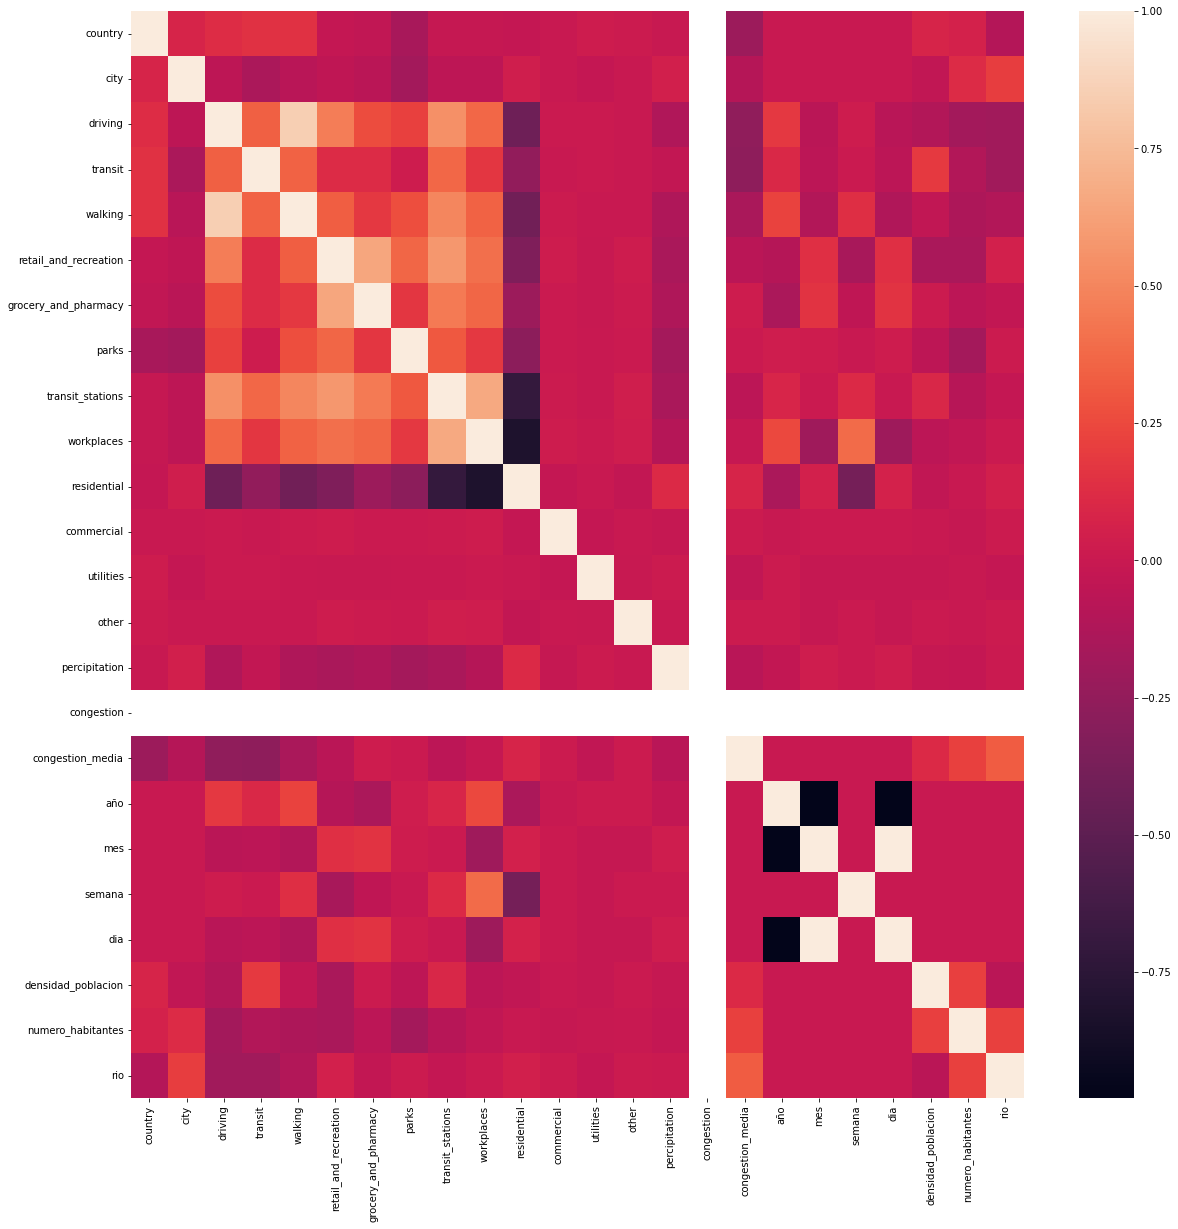

In [41]:
plt.figure(figsize=(20,20))
sns.heatmap(df_test.corr())

plt.show()

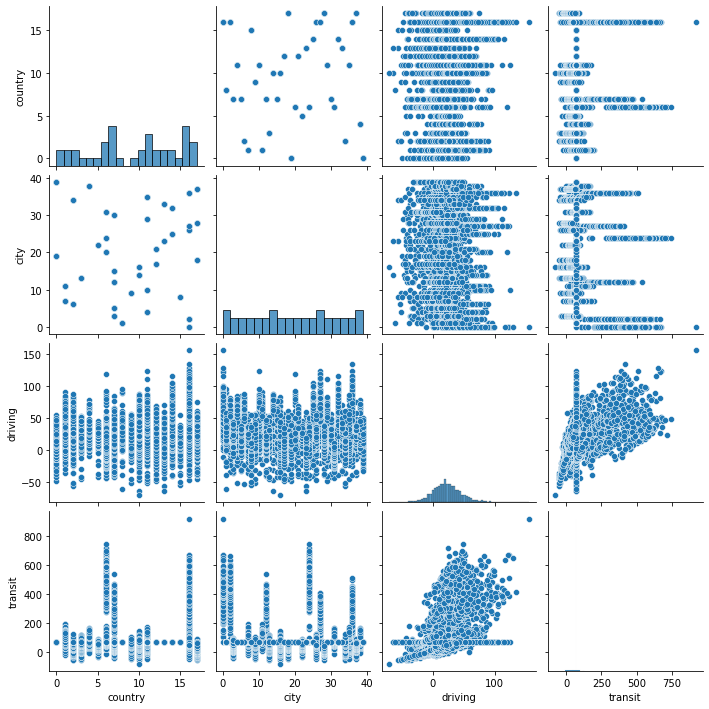

In [42]:
sns.pairplot(df_test.iloc[:,0:5])

In [43]:
# Cargamos la librería para crear el modelo de predicción y elegimos las variables que estarán en el modelo
# Se quita la variable transit debido a la gran cantidad de NaN que se encuentran en test y en algunas ciudades en train

from sklearn.tree import DecisionTreeRegressor

df_variables = ["año","mes","semana","congestion_media","driving",
                "retail_and_recreation", "grocery_and_pharmacy", 
                "transit_stations", "workplaces","residential","commercial","utilities","rio","numero_habitantes","densidad_poblacion"]

X = df[df_variables]
y = df["congestion"]

In [44]:
df = df.sort_values("date")
df

country  city       date  congestion  driving  transit  \
id                                                                             
Graz 2019-12-30             0    19 2019-12-30        23.0     1.62     1.60   
Catania 2019-12-30         11    10 2019-12-30        32.0     1.62     1.60   
Milan 2019-12-30           11    29 2019-12-30        15.0     1.62     1.60   
Rome 2019-12-30            11    35 2019-12-30        29.0     1.62     1.60   
Eindhoven 2019-12-30       12    17 2019-12-30        20.0     1.62     1.60   
...                       ...   ...        ...         ...      ...      ...   
Cologne 2021-11-30          7    12 2021-11-30        42.0     8.26   219.68   
Dresden 2021-11-30          7    15 2021-11-30        31.0     9.35     1.60   
Munich 2021-11-30           7    30 2021-11-30        36.0     5.07     1.60   
Budapest 2021-11-30         9     9 2021-11-30        41.0    12.79    39.65   
Stockholm 2021-11-30       17    37 2021-11-30        44.0    31.31    30.30   

                      walking  retail_and_recreation  grocery_and_pharmacy  \
id                                                                           
Graz 2019-12-30         -4.86                  -24.0                  -3.0   
Catania 2019-12-30      -4.86                  -24.0                  -3.0   
Milan 2019-12-30        -4.86                  -24.0                  -3.0   
Rome 2019-12-30         -4.86                  -24.0                  -3.0   
Eindhoven 2019-12-30    -4.86                  -24.0                  -3.0   
...                       ...                    ...                   ...   
Cologne 2021-11-30       5.28                   -8.0                  21.0   
Dresden 2021-11-30       6.84                  -14.0                  19.0   
Munich 2021-11-30       -3.34                  -17.0                  14.0   
Budapest 2021-11-30     12.07                  -10.0                  11.0   
Stockholm 2021-11-30    13.39                  -16.0                  -7.0   

                      parks  ...  other  percipitation  congestion_media  \
id                           ...                                           
Graz 2019-12-30        10.0  ...    1.0            0.0         23.022956   
Catania 2019-12-30     10.0  ...    1.0            0.0         25.074605   
Milan 2019-12-30       10.0  ...    1.0            0.0         22.691535   
Rome 2019-12-30        10.0  ...    1.0            0.0         28.317073   
Eindhoven 2019-12-30   10.0  ...    1.0            0.0         17.672884   
...                     ...  ...    ...            ...               ...   
Cologne 2021-11-30     -8.0  ...    1.0           54.0         24.863702   
Dresden 2021-11-30    -10.0  ...    1.0           18.0         29.192253   
Munich 2021-11-30       2.0  ...    1.0            7.0         25.764706   
Budapest 2021-11-30     9.0  ...    1.0            0.0         30.770445   
Stockholm 2021-11-30   -5.0  ...    1.0            0.0         25.149211   

                         año   mes  semana    dia  densidad_poblacion  \
id                                                                      
Graz 2019-12-30       2019.0  12.0     0.0  364.0             2268.87   
Catania 2019-12-30    2019.0  12.0     0.0  364.0             1694.00   
Milan 2019-12-30      2019.0  12.0     0.0  364.0             2200.00   
Rome 2019-12-30       2019.0  12.0     0.0  364.0             2232.00   
Eindhoven 2019-12-30  2019.0  12.0     0.0  364.0             2652.98   
...                      ...   ...     ...    ...                 ...   
Cologne 2021-11-30    2021.0  11.0     1.0  334.0             2457.00   
Dresden 2021-11-30    2021.0  11.0     1.0  334.0             1599.00   
Munich 2021-11-30     2021.0  11.0     1.0  334.0             4713.00   
Budapest 2021-11-30   2021.0  11.0     1.0  334.0             1089.00   
Stockholm 2021-11-30  2021.0  11.0     1.0  334.0             7300.00   

                      numer

In [45]:
# Separamos con train_test_split y calculamos el error

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)


# Función para calcular el error medio absoluto
def get_mae(max_leaf_nodes, train_x, val_x, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_x, train_y)
    preds_val = model.predict(val_x)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

numero_nodos = [5,25,50,100,150,200,250,300,500,1000,1500,2500,4000,5000]

# Nos indica el mejor numero de nodos para minimizar el mae y conseguir un mejor modelo (escogiendo el mejor de todos)
for max_leaf_nodes in numero_nodos:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

candidate_max_leaf_nodes = numero_nodos
scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key = scores.get)
print("El mejor número de nodos es: ",best_tree_size)

Max leaf nodes: 5  		 Mean Absolute Error:  6
Max leaf nodes: 25  		 Mean Absolute Error:  4
Max leaf nodes: 50  		 Mean Absolute Error:  4
Max leaf nodes: 100  		 Mean Absolute Error:  3
Max leaf nodes: 150  		 Mean Absolute Error:  3
Max leaf nodes: 200  		 Mean Absolute Error:  3
Max leaf nodes: 250  		 Mean Absolute Error:  3
Max leaf nodes: 300  		 Mean Absolute Error:  3
Max leaf nodes: 500  		 Mean Absolute Error:  3
Max leaf nodes: 1000  		 Mean Absolute Error:  3
Max leaf nodes: 1500  		 Mean Absolute Error:  3
Max leaf nodes: 2500  		 Mean Absolute Error:  3
Max leaf nodes: 4000  		 Mean Absolute Error:  3
Max leaf nodes: 5000  		 Mean Absolute Error:  3
El mejor número de nodos es:  1000


In [52]:
# Creamos el modelo (DecisionTree)

modelo_final = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state = 1)
modelo_final.fit(X,y)

# Validación

val_predictions = modelo_final.predict(val_X)
val_mae = mean_absolute_error(val_y, val_predictions)

print("El modelo utilizará el mejor número de nodos ya comentado antes: ", best_tree_size)
print('\n MAE - Error Medio Absoluto del modelo que utilizaremos:\n', val_mae)


# Aplicamos el modelo en test para obtener las predicciones

y_test = df_test.congestion

df_test_variables = df_variables
x_test = df_test[df_test_variables]

val_predictions_test = modelo_final.predict(x_test,160)
print('\n Predicciones:\n', val_predictions_test)


El modelo utilizará el mejor número de nodos ya comentado antes:  1000

 MAE - Error Medio Absoluto del modelo que utilizaremos:
 2.3756194070927132

 Predicciones:
 [38.         32.67213115 42.36363636 ... 24.04878049 17.14772727
 22.        ]


In [47]:
# Guardamos las predicciones para comprobación de score en la competición
output = pd.DataFrame({'id': x_test.index,
                       'congestion': val_predictions_test})
output.to_csv('DecissionTreeRegressorGonzalo.csv', index=False)